In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt

In [312]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-3.train"
TS_PATH = "./monks/datasets/monks-3.test"

In [313]:

def plot_graph(train_losses,validation_losses,epochs):
    num_epochs = list(range(1, epochs + 1))  
    # Plotting
    plt.plot(num_epochs, train_losses, label='Training Loss')
    plt.plot(num_epochs, validation_losses, label='Test Loss')

    plt.title('Training and Validation Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [314]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size,):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [315]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [316]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
          
    return False

In [317]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    train_losses = []
    test_losses = []


    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):
      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = []


      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = []

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Early stopping
        tolerance_stopper = ToleranceStopper(patience=10, min_delta=1e-4)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler.indices)    
      print(f'Training loss: {epoch_train_loss}')
      train_losses.append(epoch_train_loss)
      # Update accuracy
      for output, target in zip(outputs, targets):
        output = 0 if output.item() < 0.5 else 1
        if output == target.item():
          epoch_train_accuracy.append(1)
        else:
          epoch_train_accuracy.append(0)
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)

        epoch_test_loss = test_loss / len(testloader.sampler.indices)    
        print(f'Test loss: {epoch_test_loss}')
        test_losses.append(epoch_test_loss)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_test_accuracy.append(1)
          else:
            epoch_test_accuracy.append(0)
        
        if tolerance_stopper.tol_stop(epoch_test_loss):
          break

    plot_graph(train_losses,test_losses,epochs)
    return network


In [318]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Early stopping
        tolerance_stopper = ToleranceStopper(patience=10, min_delta=1e-4)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))
      avg_train_loss = train_loss / len(trainloader.sampler.indices)    
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))
        avg_valid_loss = valid_loss / len(validationloader.sampler.indices) #used to find the best parameters of the model
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')
        

    return avg_valid_loss


In [319]:
input_size = 17  
output_size = 1
params_grid = {
    "hidden_size": [2, 3, 4, 5],
    "learning_rate": [0.001, 0.01, 0.1, 0.5],
    "batch_size": [32, 64],
    "weight_decay": [0.0001, 0.001, 0.01],
    "momentum": [0.01, 0.05, 0.1, 0.4],
    "epochs":[5000],
    "optimizer":[torch.optim.SGD]
}

params_grid_o = {
    "hidden_size": [4],
    "learning_rate": [0.001],
    "batch_size": [64],
    "weight_decay": [0.01],
    "momentum": [0.09],
    "epochs":[400, 600],
    "optimizer":[torch.optim.SGD]
}


# For fold results
results = {}

# Set fixed random number seed
gen = torch.Generator().manual_seed(SEED)
loss_function = nn.MSELoss()

dataset_train_part = read_ds(TR_PATH)
dataset_test_part = read_ds(TS_PATH)

dataset = dataset_train_part

# Define the K-fold Cross Validator
kfold = CV 
  
# K-fold Cross Validation model evaluation
best_params = None

actual_it = 0
total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"])
print(total_iterations)

for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"]):
    validation_avg_loss_fold = 0
    num_iterations = 0
    #print the actual percentage of the grid search
    print(f'Actual iter {(actual_it/total_iterations)*100}%')
    

    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        num_iterations += 1

    actual_it = actual_it + 1

    #validation average over all folds
    validation_avg_loss_fold /= num_iterations

    #best 
    if best_params is None or validation_avg_loss_fold < best_params[0]:
        best_params = (validation_avg_loss_fold,learning_rate,epochs,hidden_size, loss_function,momentum,opt,weight_decay,batch_size)


print(f"Best hidden size: {best_params[3]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")



384
Actual iter 0.0%
Actual iter 0.26041666666666663%
Actual iter 0.5208333333333333%
Actual iter 0.78125%
Actual iter 1.0416666666666665%
Actual iter 1.3020833333333335%
Actual iter 1.5625%
Actual iter 1.8229166666666667%
Actual iter 2.083333333333333%
Actual iter 2.34375%
Actual iter 2.604166666666667%
Actual iter 2.864583333333333%
Actual iter 3.125%
Actual iter 3.3854166666666665%
Actual iter 3.6458333333333335%
Actual iter 3.90625%
Actual iter 4.166666666666666%
Actual iter 4.427083333333334%
Actual iter 4.6875%
Actual iter 4.947916666666666%
Actual iter 5.208333333333334%
Actual iter 5.46875%
Actual iter 5.729166666666666%
Actual iter 5.989583333333334%
Actual iter 6.25%
Actual iter 6.510416666666667%
Actual iter 6.770833333333333%
Actual iter 7.03125%
Actual iter 7.291666666666667%
Actual iter 7.552083333333333%
Actual iter 7.8125%
Actual iter 8.072916666666668%
Actual iter 8.333333333333332%
Actual iter 8.59375%
Actual iter 8.854166666666668%
Actual iter 9.114583333333332%
Actu

In [320]:
#Best parameters found
print(f"Best hidden size: {best_params[3]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")

Best hidden size: 5 
Best learning rate: 0.5 
Best batch size: 64 
Best weight decay: 0.001 
Best momentum: 0.4


Starting epoch 1
Training loss: 0.24275894756199884
Test loss: 0.24317353632715014
Starting epoch 2
Training loss: 0.2255203828948443
Test loss: 0.22662917717739386
Starting epoch 3
Training loss: 0.21396625164102334
Test loss: 0.21605952304822426
Starting epoch 4
Training loss: 0.20544431981493216
Test loss: 0.20709747241603005
Starting epoch 5
Training loss: 0.19715424199573328
Test loss: 0.19842387515085716
Starting epoch 6
Training loss: 0.18840809996987953
Test loss: 0.1891381326648924
Starting epoch 7
Training loss: 0.17894944963885134
Test loss: 0.17985071297045108
Starting epoch 8
Training loss: 0.16968134534163554
Test loss: 0.16983197629451752
Starting epoch 9
Training loss: 0.15908207756574036
Test loss: 0.1592238837922061
Starting epoch 10
Training loss: 0.1500666363806021
Test loss: 0.14846778964554821
Starting epoch 11
Training loss: 0.14123925933095274
Test loss: 0.13842996127075619
Starting epoch 12
Training loss: 0.12969966477057973
Test loss: 0.12736014469906135
Start

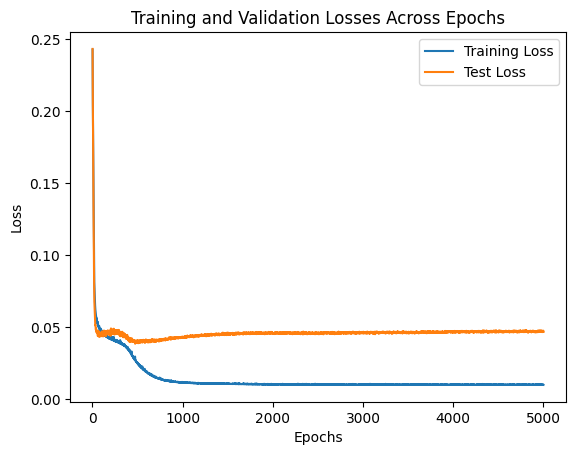

In [321]:
train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

trainloader = torch.utils.data.DataLoader(
                      dataset_train_part, 
                      batch_size=best_params[8], sampler=train_subsampler)

test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
testloader = torch.utils.data.DataLoader(
                      dataset_test_part, 
                      batch_size=best_params[8], sampler=test_subsampler)


best_net = fit_model(learning_rate=best_params[1],epochs=best_params[2],hidden_size=best_params[3],input_size=17,loss_function=best_params[4],momentum=best_params[5],opt=best_params[6],output_size=1,trainloader=trainloader,weight_decay=best_params[7],testloader=testloader)   

accuracy on test set 0.942
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       204
           1       0.97      0.92      0.94       228

    accuracy                           0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.94      0.94      0.94       432



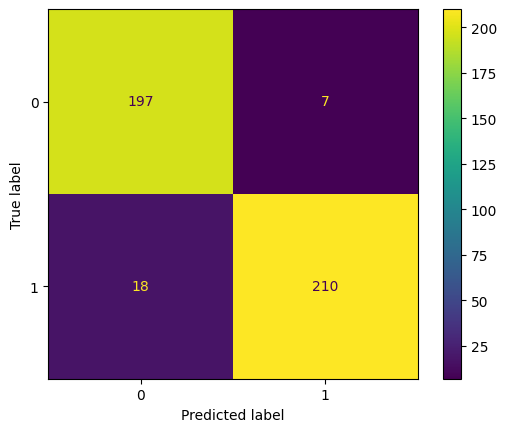

------------------------------------------------------------------------------------------------------


In [322]:
from sklearn.metrics import accuracy_score, classification_report
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
